# Projeto Integrador - Bitpy

In [109]:
#######Manipulação de dados e operações matemáticas
import pandas as pd
import numpy as np
import array

#######Padronização de respostas rest
import json
import mysql.connector

#######Api de consulta de CriptoMoedas e Índices 
#import yfinance as yf
#from mercado_bitcoin import DataAPI

#######Conversão de dados temporais
import datetime as dt

#Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import os
#from bokeh.plotting import figure, ColumnDataSource
#from bokeh.models.widgets import Dropdown
#from bokeh.io import curdoc, push_notebook, show, output_notebook
#from bokeh.layouts import column, row
#from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
#from bokeh.palettes import Category20
#from bokeh.models.formatters import NumeralTickFormatter
#from feature_engine import categorical_encoders as ce

#Pre-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


#Otimização de Modelos
#import optuna
from sklearn.model_selection import GridSearchCV


#Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb 
#import xgboost as xgb 

#Explicação do modelo
#import shap 

#Avaliação de Modelos
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

In [111]:
###Conexão à base de dados
def getConnection():
    my_db = mysql.connector.connect(
      host="localhost",
      user="root",
      password="root",
      database="coindb",
      port="8888"
    )
    return my_db

###Classe para padronização dos objetos manipulados
class Sumary():
    def __init__(self, coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price):
        self.coin = coin
        self.date = date
        self.opening = opening
        self.closing = closing
        self.lowest = lowest
        self.highest = highest
        self.volume = volume
        self.quantity = quantity
        self.amount = amount
        self.avg_price = avg_price

###Criação padronizada de tabelas
def create_table(coin_name):
    print()
    command = f"CREATE TABLE {coin_name}_day_sumary (id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT, coin varchar(5) NOT NULL, date date NOT NULL, opening double NOT NULL, closing double NOT NULL, lowest double NOT NULL, highest double NOT NULL, volume double NOT NULL, quantity double NOT NULL, amount double NOT NULL, avg_price double NOT NULL)"
    cnn = getConnection()
    cnn.cursor().execute(f"drop table if exists {coin_name}_day_sumary;")
    cnn.commit()
    cnn.cursor().execute(command)
    cnn.commit()

###Solicita uma lista de papéis ou índices com base em uma data inicial até os dias de hoje
def getStock(stock_array, date_init):
    bag_amount = 20
    bag_control = 0
    date_now = dt.date.today()
    for stock in stock_array:
        bag_control = 0
        cnn = getConnection()
        create_table(stock)
        tickerData = yf.Ticker(stock)
        tickerDf = pd.DataFrame(tickerData.history(start=date_init.strftime("%Y-%m-%d"), end=date_now.strftime("%Y-%m-%d")))
       
        for index, stk in tickerDf.iterrows():
           
            try:
                command = f"INSERT INTO {stock}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{stock}', '{index}', '{stk.Open}', '{stk.Close}', '{stk.Low}', '{stk.High}', '{stk.Volume}', '0', '0', '0')"
                print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
                    #print(calc_date)
            except Exception as e:
                print(e)
                continue
        cnn.commit()
    cnn.commit()

#Solicita o histórico de negociações de uma lista de cryptomoedas com base em uma data inicial    
def getCripto(coin_array, date_init):
    print("Dentro do Cripto")
    cnn = getConnection()
    date_now = dt.date.today()
    print("Calculando a data")
    for coin in coin_array:
        create_table(coin)
        calc_date = date_init
        bag_amount = 20
        bag_control = 0
        #Descomentar se desejar excluir todos os dados anteriores
        #command = f"delete from {coin}_day_sumary"
        #cnn.cursor().execute(command)
        #cnn.commit()
        while calc_date.date() < date_now:
            bag_control += 1
            calc_date += dt.timedelta(days=1)
            if(calc_date.weekday() > 5):
                continue
            sumary_json = DataAPI.day_summary(coin, calc_date.year, calc_date.month, calc_date.day).json()
            sumary_json["coin"] = coin
            try:
                sumary = Sumary(**sumary_json)
                command = f"INSERT INTO {coin}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{sumary.coin}', '{sumary.date}', '{sumary.opening}', '{sumary.closing}', '{sumary.lowest}', '{sumary.highest}', '{sumary.volume}', '{sumary.quantity}', '{sumary.amount}', '{sumary.avg_price}')"
                #print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
            except Exception as e:
                cnn.commit()
                bag_control = 0
                #print(f"Deu erro -> {calc_date} {e}")
            bar.next()
        print("")
        cnn.commit()

#Carrega os dados de uma moeda já existente no banco
def getData(coin):
    conn = getConnection()
    mycursor = conn.cursor()
    query = f"SELECT * FROM {coin}_day_sumary;"
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return myresult

#Carrega os dados do BTC e Indices diretamente do banco    
def get_data_from_db():
    dbColumns = 'btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    #dbColumns = 'btcopening,btcclosing,btclowest,btchighest,btcvolume,btcquantity,btcamount,btcavgprice,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    query = open('data/loaddata.sql').read()
    conn = getConnection()
    mycursor = conn.cursor()
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return pd.DataFrame(myresult, columns=dbColumns)


#EDA Lúcio/Edu
def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result

def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique())>2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5*iqr_range
            upper = q3 + 1.5*iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc


#o que interessa
def EDA_LucioEdu(df):
    df= df.rename(columns=str.lower)

    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    colunas = df.columns.tolist()
      
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), colunas), index=colunas)

    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['Mean'] = df.mean().round(3)
    eda_df['STD'] = df.std().round(3)
    
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

#Plotagem padrão do histórico do papel
def plot_stock_price_default(df):
    df = df.reset_index()
    stock = ColumnDataSource(
    data=dict(opening=[], closing=[], highest=[], lowest=[],index=[]))
    stock.data = stock.from_df(df)

    p = figure(plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
               title="Stock price", toolbar_location='above')

    inc = stock.data['closing'] > stock.data['opening']
    dec = stock.data['opening'] > stock.data['closing']
    view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=RED, source=stock, view=view_inc)
    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=BLUE, line_color=BLUE,
           source=stock,view=view_inc, name="avg_price")
    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=RED, line_color=RED,
           source=stock,view=view_dec, name="avg_price")
    
    
    #p.legend.location = "top_left"
    #p.legend.border_line_alpha = 0
    #p.legend.background_fill_alpha = 0
    #p.legend.click_policy = "mute"
    elements = list()
    elements.append(p)

    curdoc().add_root(column(elements))
    curdoc().title = 'Bokeh stocks historical prices'
    show(p, notebook_handle = True)

def plot_stock_closing(df_closing):
    plt.figure(figsize=(22,10))
    plt.plot(df_closing['bvsp'], label='BVSP')
    plt.plot(df_closing['abev'], label='ABEV')
    plt.plot(df_closing['cmi'], label='CMI')
    plt.plot(df_closing['ggb'], label='GGB')
    plt.plot(df_closing['itu'], label='ITU')
    plt.plot(df_closing['bbd'], label='BBD')
    plt.plot(df_closing['bba'], label='BBA')
    plt.plot(df_closing['val'], label='VALE3')
    plt.plot(df_closing['ptr'], label='PTR4')
    #plt.plot(df_closing['hsi'], label='HSI - HongKong')
    plt.legend(loc="upper left", fontsize='large')
    plt.title("Closing Series")
    plt.ylabel("Closing")
    plt.show()
    

#Imprime matriz de correlação
def get_correlation(df):
    corrmat = df.corr()
    sns.set(font_scale=1.0)
    f, ax = plt.subplots(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrmat, dtype=bool))
    hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cmap='icefire',
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

def break_date(df, column):
    df['year']   = pd.to_datetime(df[column], format = MY_FORMAT).dt.year
    df['month']  = pd.to_datetime(df[column], format = MY_FORMAT).dt.month
    df['day']    = pd.to_datetime(df[column], format = MY_FORMAT).dt.day
    return df.drop(columns = [column])

#MAPE

def MAPE(y_real, y_pred):
    mape_list = []
    for i in range (0, len(y_real)):
        mape_list.append(np.abs((y_real[i] - y_pred[i])/y_real[i]))
        
    return (np.mean(mape_list))

#Parâmetros para formatação do plot
W_PLOT = 1500
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,reset'
VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]
BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]
ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]
MY_FORMAT = '%Y-%m-%d'

#Lista de campos utilizados em um sumário padrão
data_columns = ['id','coin', 'date', 'opening', 'closing', 'lowest', 'highest', 'volume', 'quantity', 'amount', 'avg_price'];

NameError: name 'Category20' is not defined

### 1 - Carregando os dados

#### 1.1 - Carregando informações do banco dados

#### 1.2 Carregando dados do CSV

In [112]:
%%time
df = pd.read_csv('nextibov.csv', sep=';', encoding='utf-8')
display(df.head())
df.shape

,bvpopening,bvpclosing,bvplowest,bvphighest,ptropening,ptrclosing,ptrlowest,ptrhighest,abeopening,abeclosing,...,bbdhighest,bbaopening,bbaclosing,bbalowest,bbahighest,valopening,valclosing,vallowest,valhighest,date
0,50005,48512,48345,50005,9.267745,8.683292,8.674016,9.267745,12.714064,12.619536,...,12.644730,16.657421,16.102884,15.797178,16.828048,16.854504,16.528288,16.357412,17.048680,2015-01-02
1,48512,47517,47264,48512,8.479201,7.941133,7.913302,8.525585,12.532882,12.391089,...,12.395679,16.053127,15.768749,15.569684,16.138441,16.124397,16.279737,15.930221,16.411777,2015-01-05
2,47517,48001,47338,48061,8.080288,7.681376,7.458728,8.191613,12.391089,12.863731,...,12.648795,15.804296,15.989141,15.626560,16.188206,16.365176,16.932171,16.365176,17.188483,2015-01-06
3,48006,49463,48006,49882,7.941133,8.043180,7.755591,8.098841,12.871608,13.044909,...,13.297638,16.309067,16.692976,16.166877,17.119543,17.336059,17.553537,17.064212,17.716645,2015-01-07
4,49463,49943,49017,50261,8.154505,8.562694,8.108120,8.711127,13.738965,13.830949,...,13.336855,16.899150,16.749851,16.508130,17.048448,17.685577,17.739946,17.172952,17.771014,2015-01-08


Wall time: 70.4 ms


(1528, 37)

### 2 - Análise exploratória de dados

In [113]:
display(df.info())
display(EDA_LucioEdu(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bvpopening  1528 non-null   int64  
 1   bvpclosing  1528 non-null   int64  
 2   bvplowest   1528 non-null   int64  
 3   bvphighest  1528 non-null   int64  
 4   ptropening  1528 non-null   float64
 5   ptrclosing  1528 non-null   float64
 6   ptrlowest   1528 non-null   float64
 7   ptrhighest  1528 non-null   float64
 8   abeopening  1528 non-null   float64
 9   abeclosing  1528 non-null   float64
 10  abelowest   1528 non-null   float64
 11  abehighest  1528 non-null   float64
 12  cmiopening  1528 non-null   float64
 13  cmiclosing  1528 non-null   float64
 14  cmilowest   1528 non-null   float64
 15  cmihighest  1528 non-null   float64
 16  ggbopening  1528 non-null   float64
 17  ggbclosing  1528 non-null   float64
 18  ggblowest   1528 non-null   float64
 19  ggbhighest  1528 non-null  

None

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Mean,STD,Normality,Amount_Outliers,%_Outliers
bvpopening,0,0.0,int64,1528,1509,37501,125075,76543.287,22278.933,not_applicable,0.0,0.00
bvpclosing,0,0.0,int64,1528,1504,37497,125077,76588.512,22296.094,not_applicable,0.0,0.00
bvplowest,0,0.0,int64,1528,1506,37046,123227,75797.681,22109.449,not_applicable,0.0,0.00
bvphighest,0,0.0,int64,1528,1496,38031,125324,77326.228,22449.411,not_applicable,0.0,0.00
ptropening,0,0.0,float64,1528,1501,3.896349,31.459999,17.147,7.195,not_applicable,0.0,0.00
ptrclosing,0,0.0,float64,1528,1256,3.896351,31.120001,17.120,7.187,not_applicable,0.0,0.00
ptrlowest,0,0.0,float64,1528,1511,3.822133,30.629999,16.853,7.127,not_applicable,0.0,0.00
ptrhighest,0,0.0,float64,1528,1506,3.961289,31.76,17.414,7.253,not_applicable,0.0,0.00
abeopening,0,0.0,float64,1528,1524,10.404014,22.386441,16.304,2.046,not_applicable,132.0,0.09
abeclosing,0,0.0,float64,1528,1229,10.694901,22.276297,16.303,2.052,not_applicable,124.0,0.08


### Análise: Efetuando uma análise preliminar dos dados é possível perceber que não possuímos valores nulos (NAN) no dataset. Outro ponto importante é o fato que de acordo com os valores mínimos e máximos de cada feature, mesmo que de forma intuitiva, não é possível detectarmos outliers. Um problema visível é a grande diferença de escala de algumas características, principalmente entre as features que expressão valores e as que expressão quantidade, como por exemplo btcclosing e btcquantity.

### 3 - Verificando a correlação entre as features

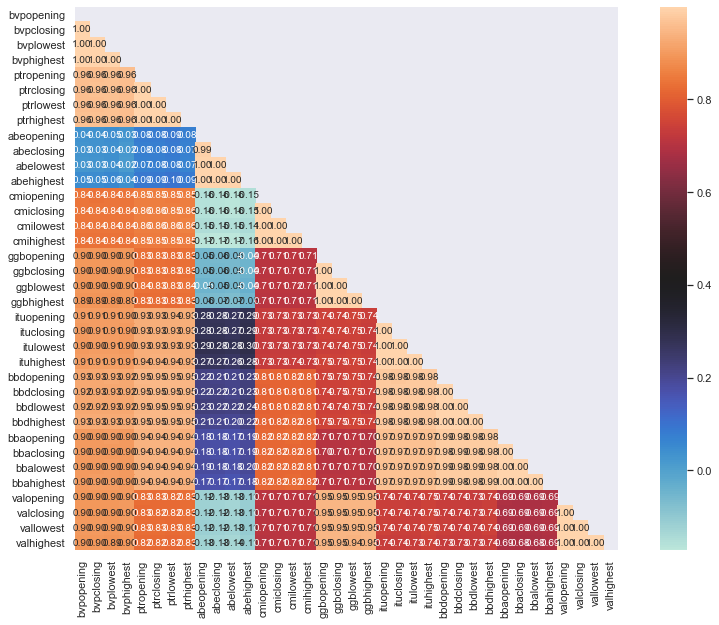

In [114]:
get_correlation(df)

#### 3.1 - Excluindo colunas com alta correlação

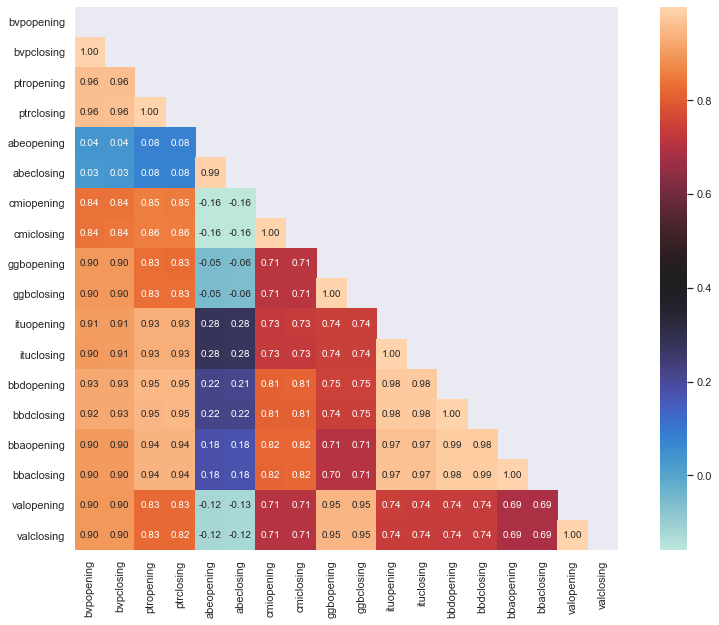

In [115]:
columns_to_remove = ['bvplowest','bvphighest', 'ptrlowest','ptrhighest', 'abelowest', 'abehighest', 'cmilowest', 'cmihighest', 'ggblowest', 'ggbhighest', 'itulowest', 'ituhighest', 'bbdlowest', 'bbdhighest', 'bbalowest', 'bbahighest', 'vallowest', 'valhighest']
df2 = df.drop(columns = columns_to_remove)
get_correlation(df2)

#### 3.2 - Criando um dataset somente com os fechamentos para verificar graficamente o comportamento da criptomoeda em relação aos índices

,bvsp,abev,cmi,ggb,itu,bbd,bba,val,ptr,year,month,day
0,48512,12.619536,8.505447,8.278129,13.944720,12.220745,16.102884,16.528288,8.683292,2015,1,2
1,47517,12.391089,8.286166,7.898978,14.014783,12.245946,15.768749,16.279737,7.941133,2015,1,5
2,48001,12.863731,8.213074,8.729500,14.241498,12.648795,15.989141,16.932171,7.681376,2015,1,6
3,49463,13.044909,8.213074,9.370446,14.756746,13.151472,16.692976,17.553537,8.043180,2015,1,7
4,49943,13.830949,8.146624,9.153788,14.987583,13.219210,16.749851,17.739946,8.562694,2015,1,8


None

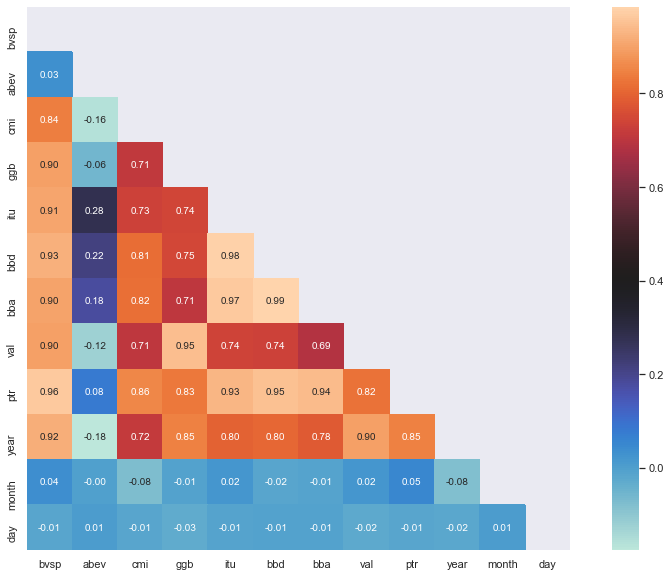

In [116]:
df2 = break_date(df2, 'date')
df_closing = pd.DataFrame(columns = ['bvsp', 'abev', 'cmi', 'ggb', 'itu','bbd','bba', 'val', 'ptr','year', 'month', 'day'])
df_closing['bvsp'] = df2['bvpclosing']
df_closing['abev'] = df2['abeclosing']
df_closing['cmi'] = df2['cmiclosing']
df_closing['ggb'] = df2['ggbclosing']
df_closing['itu'] = df2['ituclosing']
df_closing['bbd'] = df2['bbdclosing']
df_closing['bba'] = df2['bbaclosing']
df_closing['val'] = df2['valclosing']
df_closing['ptr'] = df2['ptrclosing']
df_closing['year'] = df2['year']
df_closing['month'] = df2['month']
df_closing['day'] = df2['day']
display(df_closing.head())
display(get_correlation(df_closing))

#### 3.3 - Ajustando os dados em uma mesma escala para verificar graficamente se existe alguma correlação entre eles no decorrer do tempo

,bvsp,abev,cmi,ggb,itu,bbd,bba,val,ptr
0,-1.259669,-1.795888,0.019524,-0.785328,-1.352739,-1.133622,-1.111123,-0.956142,-1.174232
1,-1.304311,-1.907256,-0.054145,-0.859151,-1.343003,-1.129717,-1.141829,-0.969317,-1.277531
2,-1.282596,-1.676842,-0.078700,-0.697443,-1.311499,-1.067299,-1.121576,-0.934732,-1.313686
3,-1.217002,-1.588517,-0.078700,-0.572647,-1.239900,-0.989413,-1.056895,-0.901793,-1.263328
4,-1.195467,-1.205320,-0.101024,-0.614832,-1.207823,-0.978917,-1.051669,-0.891911,-1.191018


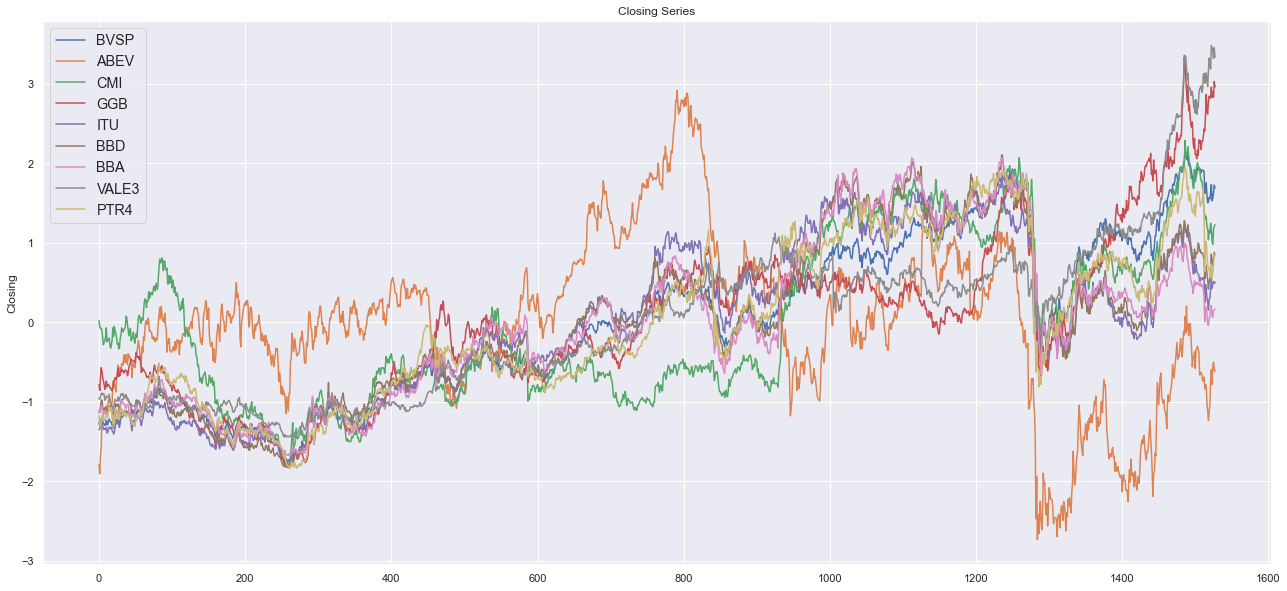

In [117]:
df_closing_scaler = pd.DataFrame(StandardScaler().fit(df_closing).fit_transform(df_closing), columns = df_closing.columns)
df_closing_scaler = df_closing_scaler.drop(columns = ['year', 'month', 'day'])
display(df_closing_scaler.head())
plot_stock_closing(df_closing_scaler)

#### Análise: Após ajustar os dados à uma mesma escala é possível perceber que os picos de alta, baixa e a tendência em alguns intervalos são muito semelhantes. Neste sentido, é possivel inferir que existe uma correlação entre os dados em um mesmo momento. Por outro lado, não é possível afirmar que o estado passado das séries representa de alguma forma o status de fechamento ou os valores futuros do Bitcopin.

### 4 - Feature Engineering
#### 4.1 - Criando novas features que possibilitem análise de sériers temporais

In [118]:
df_closing_1 = df_closing.copy() # vou dropar essa feature porque está com valores muito estranhos
df_closing_1['day'] = df2['day'].astype(str)
df_closing_1['month'] = df_closing['month'].astype(str)
df_closing_1['year'] = df_closing['year'].astype(str)
df_closing_1['data'] = df_closing_1[['day', 'month', 'year']].agg('-'.join, axis=1)
df_closing_1['day'] = df2['day'].astype(int)
df_closing_1['month'] = df_closing['month'].astype(int)
df_closing_1['year'] = df_closing['year'].astype(int)
df_closing_1['date'] = pd.to_datetime(df_closing_1['data'], format='%d-%m-%Y')
df_closing_1['day_of_year'] = df_closing_1.date.apply(lambda x: x.dayofyear)
df_closing_1['week_of_year'] = df_closing_1.date.apply(lambda x: x.weekofyear)
df_closing_1['day'] = df2['day'].astype(int)
df_closing_1['initial_month'] = np.where(df_closing_1['day'] < 5, 1, 0)
del df_closing_1['data']

#### 4.2 - Criando Lag Featuers que representam o comportamento semanal e mensal do fechamento dos índices

In [119]:
window = 5  # janela semanal, 5 dias úteis
df_closing_2 = df_closing_1.copy()

df_closing_2['week_median_bvsp'] = df_closing_1['bvsp'].rolling(window=window).mean().round(2)
#df_closing_2['week_median_abev'] = df_closing_1['abev'].rolling(window=window).mean().round(2)
#df_closing_2['week_median_cmi'] = df_closing_1['cmi'].rolling(window=window).mean().round(2)
df_closing_2['week_median_ggb'] = df_closing_1['ggb'].rolling(window=window).mean().round(2)
df_closing_2['week_median_itu'] = df_closing_1['itu'].rolling(window=window).mean().round(2)
df_closing_2['week_median_bbd'] = df_closing_1['bbd'].rolling(window=window).mean().round(2)
df_closing_2['week_median_bba'] = df_closing_1['bba'].rolling(window=window).mean().round(2)
df_closing_2['week_median_val'] = df_closing_1['val'].rolling(window=window).mean().round(2)
df_closing_2['week_median_ptr'] = df_closing_1['ptr'].rolling(window=window).mean().round(2)

df_closing_3 = df_closing_2.copy()


df_closing_3['variacao_sem_bvsp'] = df_closing_3['bvsp'].pct_change(window - 1).round(4)
#df_closing_3['variacao_sem_abev'] = df_closing_3['abev'].pct_change(window - 1).round(4)
#df_closing_3['variacao_sem_cmi'] = df_closing_3['cmi'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_ggb'] = df_closing_3['ggb'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_itu'] = df_closing_3['itu'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_bbd'] = df_closing_3['bbd'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_bba'] = df_closing_3['bba'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_val'] = df_closing_3['val'].pct_change(window - 1).round(4)
df_closing_3['variacao_sem_ptr'] = df_closing_3['ptr'].pct_change(window - 1).round(4)


# correlação entre bvsp e as demais

#df_closing_3['corr_bvsp_abev'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['abev'])
#df_closing_3['corr_bvsp_cmi'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['cmi'])
df_closing_3['corr_bvsp_ggb'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['ggb'])
df_closing_3['corr_bvsp_itu'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['itu'])
df_closing_3['corr_bvsp_bbd'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['bbd'])
df_closing_3['corr_bvsp_bba'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['bba'])
df_closing_3['corr_bvsp_val'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['val'])
df_closing_3['corr_bvsp_ptr'] = df_closing_3['bvsp'].rolling(window).corr(df_closing_3['ptr'])


df_closing_4 = df_closing_3.copy()
df_closing_4['week_median_bvsp'].shift(periods=window)
#df_closing_4['week_median_abev'].shift(periods=window)
#df_closing_4['week_median_cmi'].shift(periods=window)
df_closing_4['week_median_ggb'].shift(periods=window)
df_closing_4['week_median_itu'].shift(periods=window)
df_closing_4['week_median_bbd'].shift(periods=window)
df_closing_4['week_median_bba'].shift(periods=window)
df_closing_4['week_median_val'].shift(periods=window)
df_closing_4['week_median_ptr'].shift(periods=window)

df_closing_4['variacao_sem_bvsp'].shift(periods=window)
#df_closing_4['variacao_sem_abev'].shift(periods=window)
#df_closing_4['variacao_sem_cmi'].shift(periods=window)
df_closing_4['variacao_sem_ggb'].shift(periods=window)
df_closing_4['variacao_sem_itu'].shift(periods=window)
df_closing_4['variacao_sem_bbd'].shift(periods=window)
df_closing_4['variacao_sem_bba'].shift(periods=window)
df_closing_4['variacao_sem_val'].shift(periods=window)
df_closing_4['variacao_sem_ptr'].shift(periods=window)

#df_closing_4['corr_bvsp_abev'].shift(periods=window)
#df_closing_4['corr_bvsp_cmi'].shift(periods=window)
df_closing_4['corr_bvsp_ggb'].shift(periods=window)
df_closing_4['corr_bvsp_itu'].shift(periods=window)
df_closing_4['corr_bvsp_bbd'].shift(periods=window)
df_closing_4['corr_bvsp_bba'].shift(periods=window)
df_closing_4['corr_bvsp_val'].shift(periods=window)
df_closing_4['corr_bvsp_ptr'].shift(periods=window)
df_closing_4 = df_closing_4.dropna()

#### 4.3 - Criando novas features utilizando a variação semanal e a correlação de cada ítem com o Bitcoin

#### 4.4 - Ajustando o intervalo das features de acordo com a janela de deslocamento e eliminando valores nulos

#### Análise: Para efetuar análise baseada em séries temporais é preciso posicionar os dados em relação ao tempo. Como o que se deseja prever é um valor futuro e o que efetivamente se conhece são os valores passados, é imprecindível que seja efetuado um deslocamento das features em relação ao alvo. É importante lembrar que após este deslocamento as features movimentadas apresentaram diversos NANs que devem ser removidos.

### 5 - Modelagem

#### 5.1 - Removendo os valores alvo e preparando os dados para aplicação dos modelos

In [120]:
df_closing_5 = df_closing_4.copy()
df_closing_5.index = df_closing_5.date
df_closing_5 = df_closing_5.drop(columns = ['date'])
df_closing_5.index = df_closing_5.index.to_period('D')
X = df_closing_5.drop(columns = ['bvsp'])
Y = df_closing_5.bvsp
display(X.shape)

(1524, 34)

#### 5.2 - Efetuando a divisão do dataset para efetuar treinamento e teste, mantendo os folds em ordem cronológica. Serão utilizados os cenários de 15 dias, 1 mês(30 dias), 2 meses(60 dias), 3 meses(90 dias), 6 meses(180 dias) e 1 ano(360 dias).

In [121]:
#scenarios = [15, 30, 60, 90, 180, 270, 360]
scenarios = [15]
param_max_depth = [10, 50, 100, 200]
metrica = pd.DataFrame(columns = ['Modelo', 'Periodo','Treino', 'Teste'])
models = {}
#models['LinearRegression'] = LinearRegression()
for j in param_max_depth:
    models['LGBMRegressor'] = lgb.LGBMRegressor(max_depth=j, num_leaves=20, n_estimators=1000)

    for model in models:
        metrica_final_teste = []
        metrica_final_treino = []
        diff_final_metrica = []
        for i in scenarios:
            tsp = TimeSeriesSplit(gap=0, max_train_size=i, n_splits=10, test_size = 14)
            metrica_teste = []
            metrica_treino = []
            diff_metrica = []
            for train_index, test_index in tsp.split(X.index):
                x_treino, x_teste = X.iloc[train_index], X.iloc[test_index]
                y_treino, y_teste = Y[train_index], Y[test_index]
                scaler = StandardScaler().fit(x_treino)

                x_treino_norm = scaler.fit_transform(x_treino)
                x_teste_norm = scaler.fit_transform(x_teste)

                my_model = models[model].fit(x_treino_norm, y_treino)

                pred_treino = my_model.predict(x_treino_norm)
                pred_teste = my_model.predict(x_teste_norm)

                metrica_treino.append(MAPE(y_treino, pred_treino))

                metrica_teste.append(MAPE(y_teste, pred_teste))

                #diff_metrica.append(100*np.abs((MAPE(y_treino, pred_treino) - \
                                           #MAPE(y_teste, pred_teste))/\
                                          #MAPE(y_teste, pred_teste)))
                df_r = pd.DataFrame({'Modelo' : model, 'ParamMaxDepth' : j,'Periodo': i, \
                                     'Treino':np.median(metrica_treino).round(4) ,'Teste':np.median(metrica_teste).round(4)}, index=[i])
                metrica = metrica.append(df_r, ignore_index = True)
                metrica_final_teste.append(np.median(metrica_teste))
                metrica_final_treino.append(np.median(metrica_treino))

metrica['diff'] = (metrica['Teste'] - metrica['Treino']).round(2) 
display(metrica.sort_values(by=['diff'],ascending = True))

,Modelo,Periodo,Treino,Teste,ParamMaxDepth,diff
0,LGBMRegressor,15,0.0096,0.0201,10.0,0.01
21,LGBMRegressor,15,0.0088,0.0186,100.0,0.01
20,LGBMRegressor,15,0.0096,0.0201,100.0,0.01
30,LGBMRegressor,15,0.0096,0.0201,200.0,0.01
13,LGBMRegressor,15,0.0111,0.0257,50.0,0.01
12,LGBMRegressor,15,0.0096,0.0201,50.0,0.01
22,LGBMRegressor,15,0.0096,0.0201,100.0,0.01
10,LGBMRegressor,15,0.0096,0.0201,50.0,0.01
31,LGBMRegressor,15,0.0088,0.0186,200.0,0.01
11,LGBMRegressor,15,0.0088,0.0186,50.0,0.01


## Otimização dos parâmetros para as melhores estabilidades (cenários)

In [122]:
X = df_closing_5.drop(columns = ['bvsp'])
Y = df_closing_5.bvsp

In [125]:
##Parâmetros do LGBM
max_depth_p = [1, 2, 3, 5]
#num_leaves = 2^(max_depth)
#min_data_in_leaf_p = [20, 100, 500] 
#num_iterations = []

metrica_final_teste = []
metrica_final_treino = []
diff_final_metrica = []


tsp2 = TimeSeriesSplit(gap=0, n_splits=5, max_train_size=15, test_size = 14) 

for i in range (0, len(max_depth_p)):
    
    metrica_teste = []
    metrica_treino = []
    diff_metrica = []
    
    print ('Parâmetro: ', max_depth_p[i])    
    
    for train_index, test_index in tsp2.split(X.index):
        x_treino, x_teste = X.iloc[train_index], X.iloc[test_index]
        y_treino, y_teste = Y[train_index], Y[test_index]
            
        
        scaler = StandardScaler().fit(x_treino)
            
        x_treino_norm = scaler.fit_transform(x_treino)
        x_teste_norm = scaler.fit_transform(x_teste)
            

        modelo = lgb.LGBMRegressor(max_depth=max_depth_p[i]).fit(x_treino_norm, y_treino)

        pred_treino = modelo.predict(x_treino_norm)
        pred_teste = modelo.predict(x_teste_norm)
            
        metrica_treino.append(MAPE(y_treino, pred_treino))

        metrica_teste.append(MAPE(y_teste, pred_teste))    
        
    metrica_final_teste.append(np.mean(metrica_teste))
    metrica_final_treino.append(np.mean(metrica_treino))
    diff_final_metrica.append(np.mean(diff_metrica))

Parâmetro:  1
Parâmetro:  2


C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parâmetro:  3
Parâmetro:  5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [126]:
display(metrica_treino)
display(metrica_final_treino)

np.mean(metrica_treino)

[0.02945445853347349,
 0.015895010114257212,
 0.011552408402631924,
 0.018410171773561673,
 0.010687771275450413]

[0.017199964019874944,
 0.017199964019874944,
 0.017199964019874944,
 0.017199964019874944]

0.017199964019874944

### 6 - Plataforma Bitpy

In [13]:
#LINEAR REGRESSION
result = pd.DataFrame(columns = {'data','ibov_pred','ibov_real'})
#result['data'] = date_index
result['ibov_pred'] = pred_teste.round(2)
result['ibov_real'] = y_teste.values
result['MAPE'] = 100*(result['ibov_pred'] - result['ibov_real'])/result['ibov_real']
display(result)

,data,ibov_pred,ibov_real,MAPE
0,NaN,118407.53,115227,2.760230
1,NaN,118407.53,115668,2.368442
2,NaN,118407.53,112256,5.479912
3,NaN,118407.53,110035,7.608970
4,NaN,118407.53,110335,7.316382
5,NaN,118407.53,111540,6.157011
6,NaN,118407.53,111184,6.496915
7,NaN,118407.53,112690,5.073680
8,NaN,118407.53,115202,2.782530
9,NaN,118407.53,110612,7.047635


,data,ibov_pred,ibov_real,MAPE
0,NaN,118407.53,115227,2.760230
1,NaN,118407.53,115668,2.368442
2,NaN,118407.53,112256,5.479912
3,NaN,118407.53,110035,7.608970
4,NaN,118407.53,110335,7.316382
5,NaN,118407.53,111540,6.157011
6,NaN,118407.53,111184,6.496915
7,NaN,118407.53,112690,5.073680
8,NaN,118407.53,115202,2.782530
9,NaN,118407.53,110612,7.047635


,data,ibov_pred,ibov_real,MAPE
0,NaN,118407.53,115227,2.760230
1,NaN,118407.53,115668,2.368442
2,NaN,118407.53,112256,5.479912
3,NaN,118407.53,110035,7.608970
4,NaN,118407.53,110335,7.316382
5,NaN,118407.53,111540,6.157011
6,NaN,118407.53,111184,6.496915
7,NaN,118407.53,112690,5.073680
8,NaN,118407.53,115202,2.782530
9,NaN,118407.53,110612,7.047635


,data,ibov_pred,ibov_real,MAPE
0,NaN,118407.53,115227,2.760230
1,NaN,118407.53,115668,2.368442
2,NaN,118407.53,112256,5.479912
3,NaN,118407.53,110035,7.608970
4,NaN,118407.53,110335,7.316382
5,NaN,118407.53,111540,6.157011
6,NaN,118407.53,111184,6.496915
7,NaN,118407.53,112690,5.073680
8,NaN,118407.53,115202,2.782530
9,NaN,118407.53,110612,7.047635


NameError: name 'date_index' is not defined